In [1]:
#Load small dataset - 'notmnist small'
#!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz -O notMNIST_small.tar.gz
#!tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log

In [1]:
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *
from lasagne.regularization import regularize_layer_params, l2
from lasagne.init import Normal 


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})
import numpy as np
IMG_SHAPE = (28,28)

## Load data

In [13]:
from scipy.misc import imread,imresize
import glob
import os 

data = []
classes = []

classes_lab = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
n_classes = len(classes_lab)

for letter in classes_lab:
    for path in os.listdir(os.path.join('./notMNIST_small/', letter)):
        path_letter = os.path.join('./notMNIST_small/', letter, path)
        try:
            data.append(imresize(imread(path_letter),IMG_SHAPE))

        except:
            print("failed:", path)

        else:
            classes.append(path_letter.split('/')[-2])


failed: RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
failed: Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


In [14]:
data = np.stack(data)[:,None]
data = data.astype(np.float32)
data = (data - np.mean(data))/np.std(data)/16. #all fonts


In [15]:
#convert classes to OneHotEncoder
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

letters = {l:i for i,l in enumerate(classes_lab)}

classes = np.array(list(map(letters.get, classes)))
classes = OneHotEncoder(sparse=False, dtype='float32').fit_transform(classes[:,None]) #onehotencoder letters

In [16]:
classes

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]], dtype=float32)

## Dataset

In [27]:
def plot_data(nrow = 4, ncol = 5):
    
    np.random.seed(1)
    indices = np.arange(len(data))
    np.random.shuffle(indices) 
    
    data_r = data[indices] 
    
    images = data_r[:ncol*nrow] 
    
    plt.figure(figsize=(12,12))

    for i in range(nrow*ncol):

        plt.subplot(nrow, ncol, i+1)
        plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        plt.xticks(())
        plt.yticks(())
   

    plt.show()

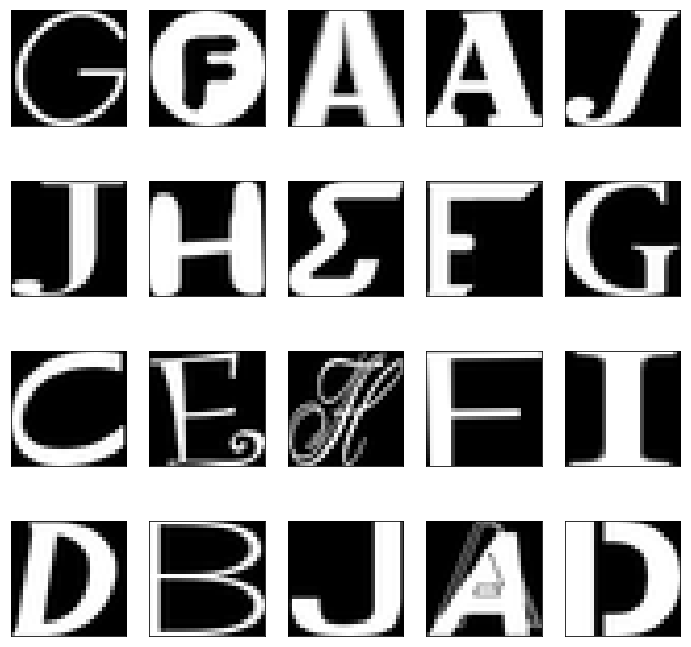

In [28]:
#Plot the dataset
plot_data()

## Generative adversial networks

In [18]:
input_img = T.tensor4('real images') 

input_classes = T.matrix('data classes 1-hot')
input_noise = T.matrix('generator noize')

In [19]:
#Generator

NOISE_SIZE = 128 # size of normal noise
CLASSES_SIZE = 10 # the number of classes = n_classes

G_in_let = InputLayer((None, NOISE_SIZE), input_var=input_noise) 
G_dense01 = DenseLayer(G_in_let, 1024, nonlinearity = lasagne.nonlinearities.tanh)

G_in_noi = InputLayer((None, CLASSES_SIZE), input_var=input_classes) 
G_dense02 = DenseLayer(G_in_noi, 1024, nonlinearity = lasagne.nonlinearities.tanh)

G_concat = lasagne.layers.concat([G_dense01, G_dense02])

G_dense = DenseLayer(G_concat, 10*8*8, nonlinearity = lasagne.nonlinearities.tanh)

G_reshape = ReshapeLayer(G_dense, ([0], 10, 8, 8))

G_deconv0 = Deconv2DLayer(G_reshape, 128, 5)

G_upscale = Upscale2DLayer(G_deconv0, 2)

G_deconv1 = Deconv2DLayer(G_upscale, 64, 3)

G_deconv2 = Deconv2DLayer(G_deconv1, 32, 3)

G_deconv3 = Deconv2DLayer(G_deconv2, 32, 3)

G = Conv2DLayer(G_deconv3, 1, 3, nonlinearity=None)

   
G_out = get_output(G)


In [20]:
#Discriminator

D_in = InputLayer((None, 1, IMG_SHAPE[0], IMG_SHAPE[1]), input_img)

D_conv = Conv2DLayer(D_in, 32, 5)

D_pool = Pool2DLayer(D_conv, 3)

D_conv1 = Conv2DLayer(D_pool, 64, 5)

D_dense = DenseLayer(D_conv1, 128, nonlinearity=lasagne.nonlinearities.tanh)

#class: from data or from generator input
D_in_class = InputLayer((None, n_classes), input_classes)

D_dense1 = DenseLayer(D_in_class, 128, nonlinearity=lasagne.nonlinearities.tanh)

#concatenate the two branches
D_concat = ConcatLayer([D_dense, D_dense1])
D_dense2 = DenseLayer(D_concat, 256)

#predicted probability of image being REAL
D = DenseLayer(D_dense2, 1, W = Normal(1e-3), nonlinearity=lasagne.nonlinearities.sigmoid) #P(real|x)

D1_out = get_output(D) # a real image is real
D2_out = get_output(D, {D_in: G_out}) #a generated image is real




In [21]:
#loss 
G_loss = -T.log(D2_out).mean()

lr = 1e-4
D_reg = regularize_layer_params(D, l2)*lr
D_loss = -(T.log(D1_out) + T.log(1 - D2_out)).mean() + D_reg

# parameters update and training
G_params = get_all_params(G, trainable=True)
G_updates = lasagne.updates.adagrad(G_loss, G_params, learning_rate = 0.01)

G_train_tn = theano.function([input_noise, input_classes], G_loss, updates = G_updates, 
                             allow_input_downcast=True)
G_pred_fn = theano.function([input_noise, input_classes], G_out, allow_input_downcast = True)


D_params = get_all_params(D, trainable=True)
D_updates = lasagne.updates.adagrad(D_loss, D_params, learning_rate = 0.01)

D_train_tn= theano.function([input_noise, input_img, input_classes], D_loss, updates=D_updates, 
                            allow_input_downcast=True)
D_pred_fn = theano.function([input_img, input_classes], D1_out, allow_input_downcast = True)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [22]:
import pickle

with open('model_gen.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()
G_params = p

with open('model_dis.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()
D_params = p

#import pickle
#G_params = pickle.load(open("model_gen.pkl", "rb"))
lasagne.layers.set_all_param_values(G, G_params)

#D_params = pickle.load(open("model_dis.pkl", "rb"))
lasagne.layers.set_all_param_values(D, D_params)



In [23]:
def iterate_minibatches(input1, input2, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(input1))
        np.random.shuffle(indices)
    for start_idx in range(0, len(input1) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield input1[excerpt], input2[excerpt]
        

In [24]:
#Generate Gaussian noise
def make_noise(batch_size):
    noise = np.random.normal(size=(batch_size, NOISE_SIZE)).astype('float32')
    return noise

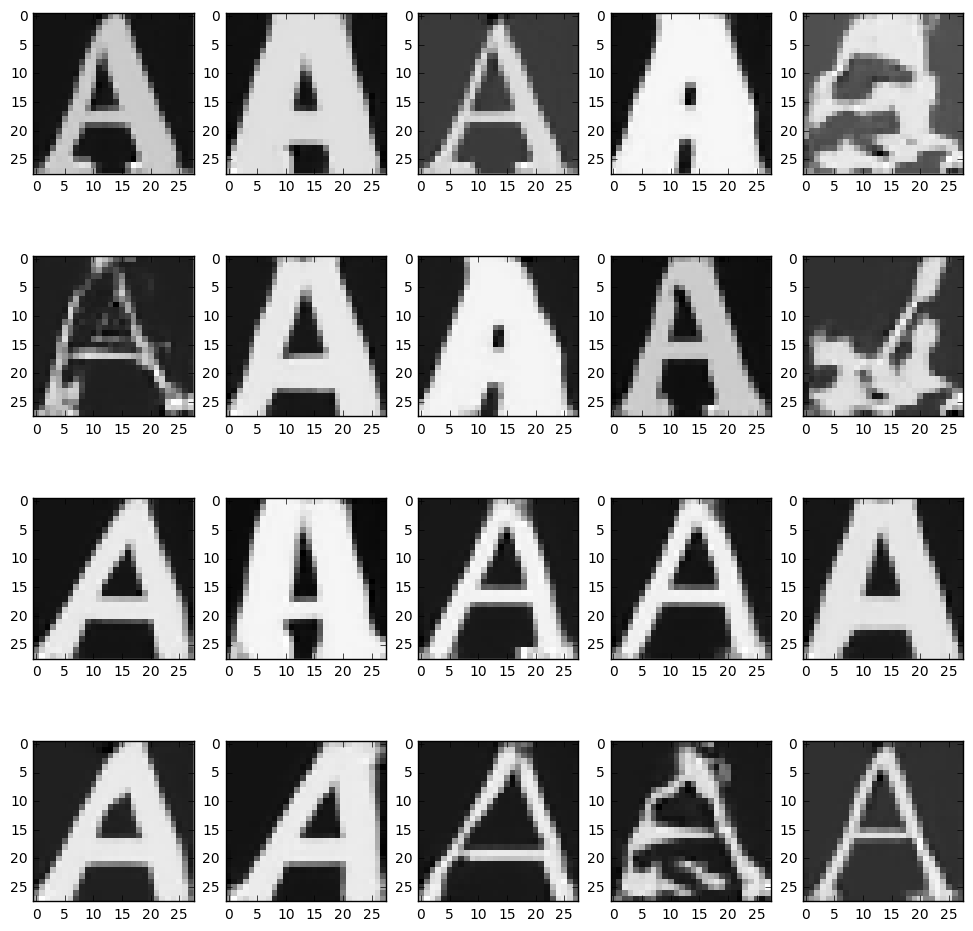

 30%|███       | 300/1000 [1:12:34<2:49:30, 14.53s/it]

("Discriminator's loss =", array(1.2111566066741943, dtype=float32))


KeyboardInterrupt: 

In [16]:
#Train NN

from IPython import display
from tqdm import tqdm

batch_size = 100

for epoch in tqdm(range(1000)): 
    
    for letter, img in iterate_minibatches(classes, data, batch_size):
        
        D_loss =  D_train_tn(make_noise(batch_size), img, letter)

        G_loss =  G_train_tn(make_noise(batch_size), letter)
    
    display.clear_output(wait=True)
    
    nrow = 4
    ncol = 5
    images = G_pred_fn(make_noise(nrow*ncol), classes[:nrow*ncol, :])
    plt.figure(figsize=(12,12))
    
    for i in range(nrow*ncol):
        
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        
    plt.show()
    print("Discriminator's loss =", D_loss)
    #sample_probas(1000)

In [28]:
#Save weights
import pickle
G_params = lasagne.layers.get_all_param_values(G, trainable=True)
output = open('model_gen2.pkl', "wb")
pickle.dump(G_params, output)
output.close()
lasagne.layers.set_all_param_values(G, G_params)

D_params = lasagne.layers.get_all_param_values(D, trainable=True)
output = open('model_dis2.pkl', "wb")
pickle.dump(D_params, output)
output.close()
lasagne.layers.set_all_param_values(D, D_params)




In [25]:
def plot_letter(letter, nrow = 4, ncol = 5):
    
    for i in range(n_classes):
        if classes_lab[i]==letter:
            break
    
    n_style = len(classes) // n_classes +1
    
    images = G_pred_fn(make_noise(nrow*ncol), classes[(n_style*i):(n_style*i + nrow*ncol), :])
    
    plt.figure(figsize=(12,12))

    for i in range(nrow*ncol):

        plt.subplot(nrow, ncol, i+1)
        plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        #plt.title(classes_lab[y[i].argmax()])

    plt.show()

### Generated images

This is generation of letter B in different styles


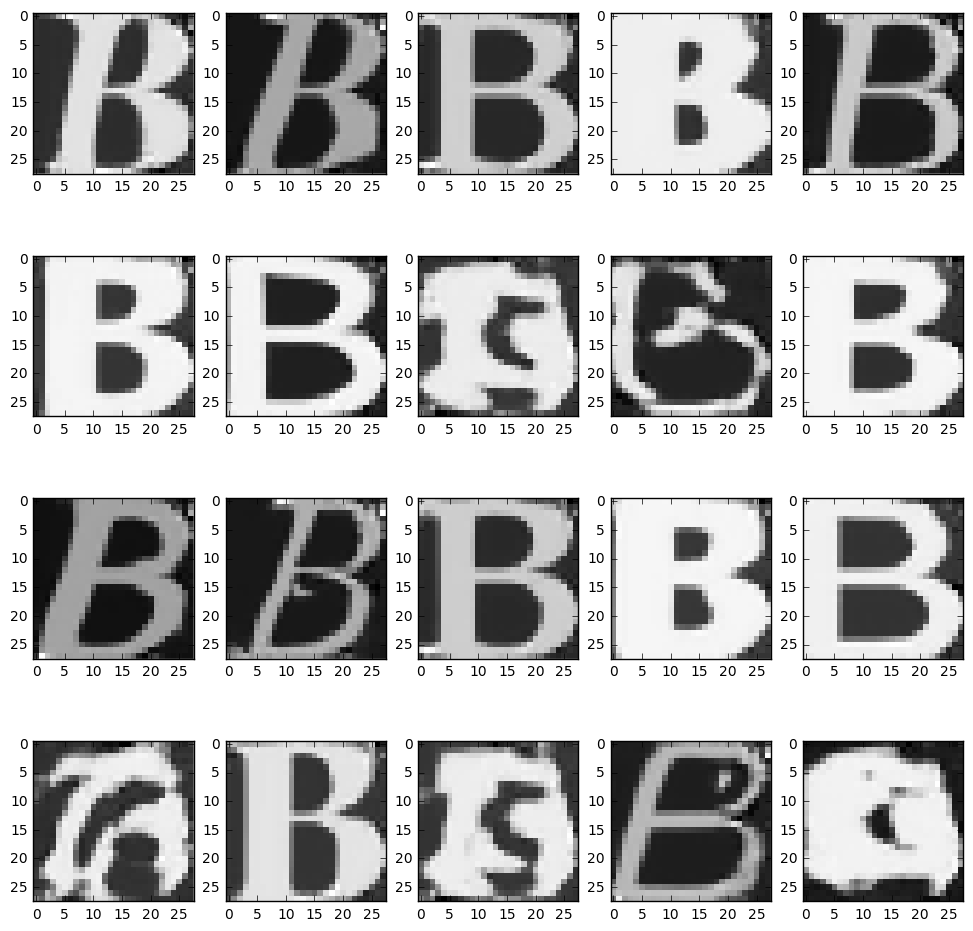

In [19]:
print('This is generation of letter B in different styles')
plot_letter(letter = 'B')

This is generation of letter F in different styles


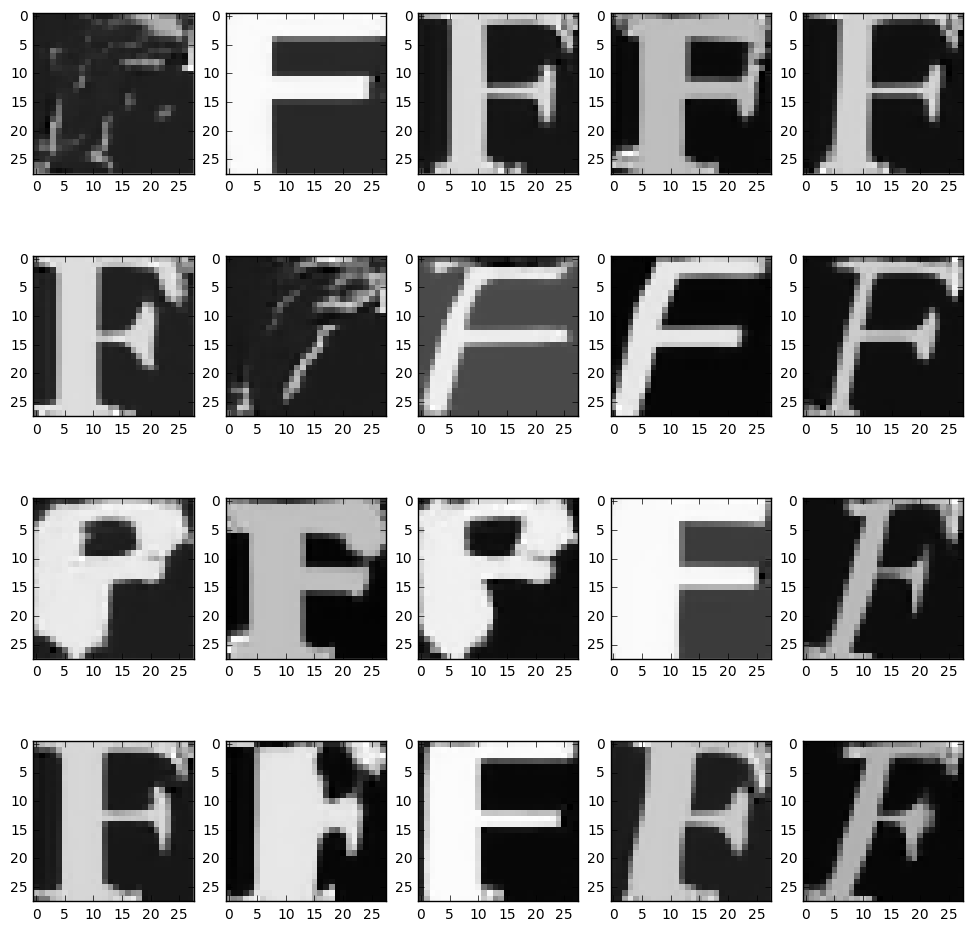

In [20]:
print('This is generation of letter F in different styles')
plot_letter(letter = 'F')

This is generation of letter G in different styles


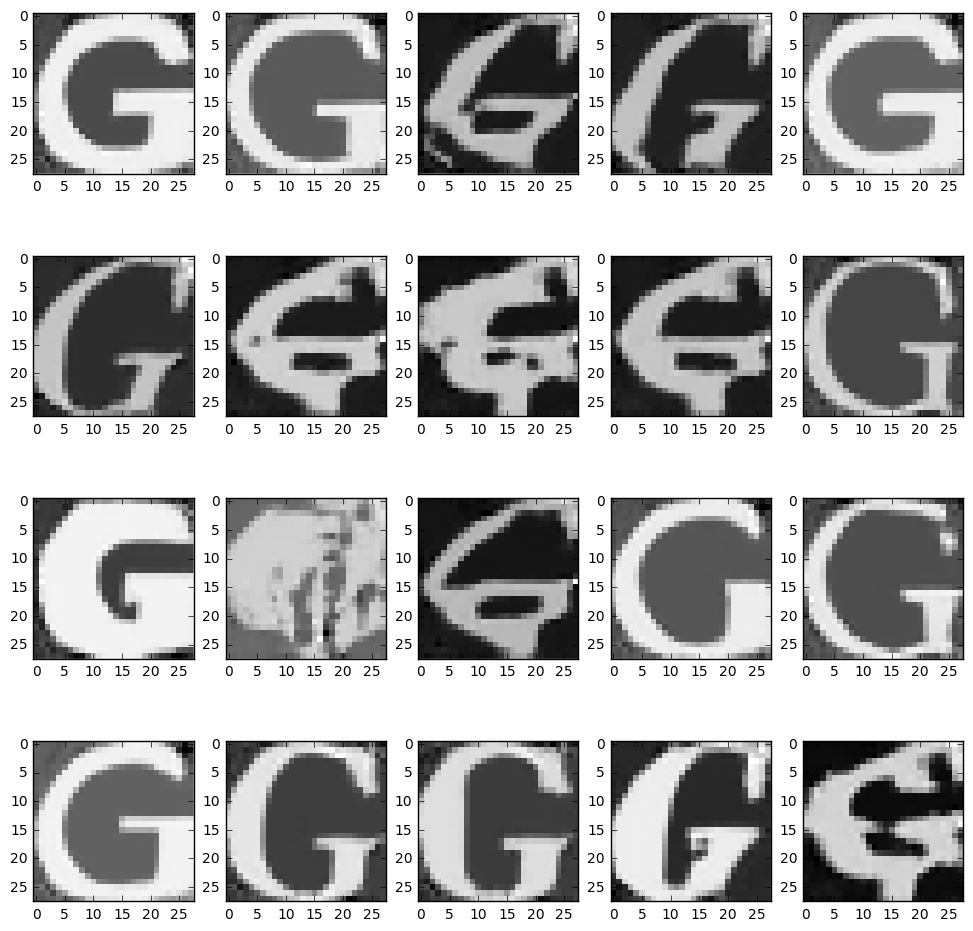

In [21]:
print('This is generation of letter G in different styles')
plot_letter(letter = 'G')

## Find the most similar real images using l1 metric

In [53]:
# Generate an image
def pot_image(letter):
    
    for i in range(n_classes):
        if classes_lab[i]==letter:
            break
    
    n_style = len(classes) // n_classes +1
    image = G_pred_fn(noise, classes[(n_style*i) :n_style*i +1, :])
    
    plt.imshow(image.reshape(IMG_SHAPE), cmap="gray", interpolation="none")
    return image

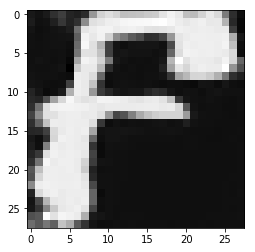

In [96]:
#Fix noise
noise = make_noise(1)
image = pot_image('F')

In [97]:
def find_similar(image, minn = 1000000, ind =0):

    for i in range(classes.shape[0]):
        if minn > np.sum(np.abs(image - data[i])):
            ind = i
            minn = np.sum(np.abs(image - data[i]))
            
    return ind

In [98]:
def plot_real_im(ind):
    
    real_image = data[ind]
    plt.imshow(real_image.reshape(IMG_SHAPE),cmap="gray", interpolation="none")
    return real_image

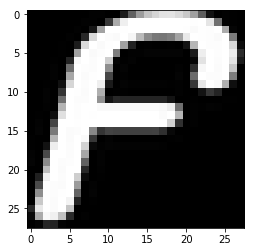

In [99]:
ind = find_similar(image)
real_image = plot_real_im(ind)

In [100]:
def plot_similar(image, real_image):    
    im = np.zeros(data[:2].shape)
    im[0] = image
    im[1] = real_image
    
    plt.figure(figsize=(12,12))

    for i in range(2):

        plt.subplot(1, 2, i+1)
        plt.imshow(im[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        #plt.title(classes_lab[y[i].argmax()])
        plt.xticks(())
        plt.yticks(())
        
    plt.show()

Generated image vs real image


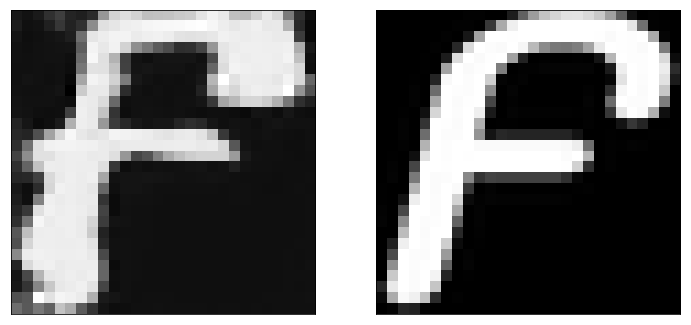

In [101]:
print('Generated image vs real image')
plot_similar(image, real_image)

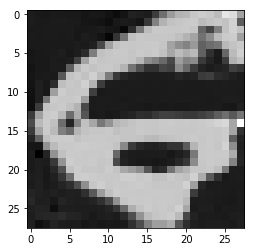

In [89]:
#Fix noise
noise = make_noise(1)
image = pot_image('G')

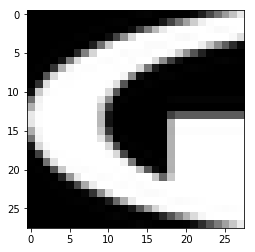

In [90]:
ind = find_similar(image)
real_image = plot_real_im(ind)

Generated image vs real image


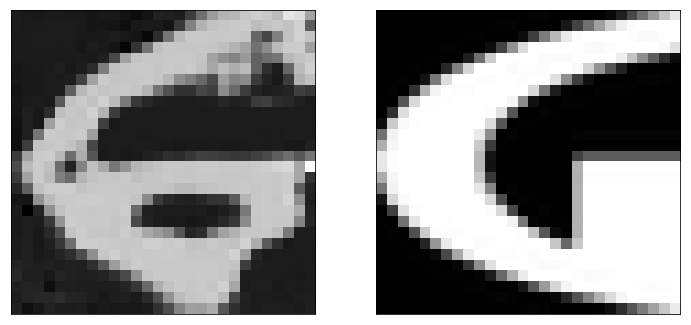

In [93]:
print('Generated image vs real image')
plot_similar(image, real_image)

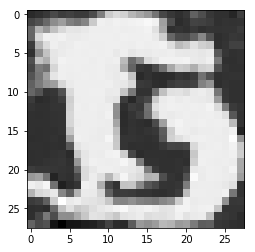

In [116]:
#Fix noise
noise = make_noise(1)
image = pot_image('B')

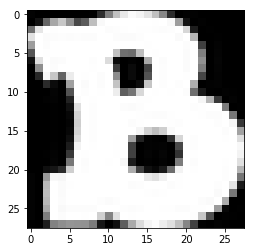

In [117]:
ind = find_similar(image)
real_image = plot_real_im(ind)

Generated image vs real image


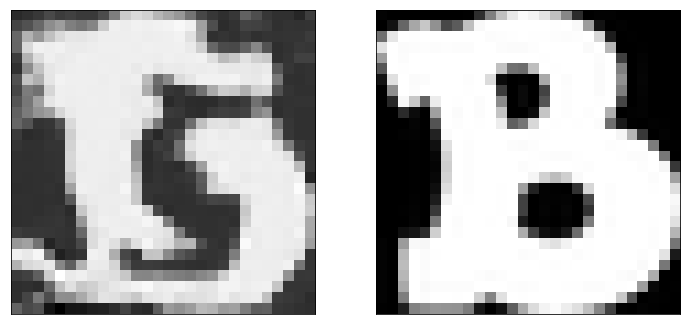

In [118]:
print('Generated image vs real image')
plot_similar(image, real_image)